In [1]:
import os
os.chdir("/hpc/users/neffr01/zhang_neffr01/zhang-ipy/Programs/")
%run ipy_setup.py
%matplotlib inline

set_matplotlib_formats("svg")
sb.set(font_scale=1)
pd.set_option('display.width', 400)
pd.set_option('display.max_rows', 200)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (4,4)
rcParams['figure.dpi'] = 200
rcParams['font.size'] = 12
rcParams['font.family'] = 'Helvetica Neue'

COLOR = 'black'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

In [2]:
basedir="/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/featureCounts/"

samples="""s_10si6
s_11si6
s_12si6
s_13si6C
s_14si6C
s_15si6C
s_16si6C
s_1sic_
s_2sic_
s_3sic_
s_4sic_
s_5sic_C
s_6sic_C
s_7sic_C
s_8sic_C
s_9si6""".strip().split("\n")

ensembldb = pd.read_csv("~/.cache/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.gtf.expanded.csv")
gene_db = ensembldb[ensembldb["feature"]=="gene"]
gene_db.set_index("gene_id",inplace=True)
os.chdir("/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/featureCounts/")

all_samples = pd.DataFrame()
for s in samples:
    print(s)
    input_file = pd.read_table("/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/featureCounts/{samp}/{samp}.primary.txt".format(samp=s),
                            skiprows=1)
    df = input_file.iloc[:,[0,6]]
    df.set_index("Geneid",inplace=True)
    df.rename(columns={df.columns[0]:s},inplace=True)
    all_samples = pd.merge(all_samples,df,how="outer",left_index=True,right_index=True)
all_samples["Symbol"] = gene_db.loc[all_samples.index,"gene_name"]
col_order = ["Symbol"]
col_order.extend(list(all_samples.columns[0:-1]))
all_samples = all_samples.loc[:,col_order]
all_samples.to_csv("MycBP2.gene_exp.primary.tsv",sep="\t")

/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


s_10si6


/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


s_11si6
s_12si6
s_13si6C
s_14si6C
s_15si6C
s_16si6C
s_1sic_
s_2sic_
s_3sic_
s_4sic_
s_5sic_C
s_6sic_C
s_7sic_C
s_8sic_C
s_9si6


In [3]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

def to_precision(x,p):
    """
    returns a string representation of x formatted with a precision of p

    Based on the webkit javascript implementation taken from here:
    https://code.google.com/p/webkit-mirror/source/browse/JavaScriptCore/kjs/number_object.cpp
    """

    x = float(x)

    if x == 0.:
        return "0." + "0"*(p-1)

    out = []

    if x < 0:
        out.append("-")
        x = -x

    e = int(math.log10(x))
    tens = math.pow(10, e - p + 1)
    n = math.floor(x/tens)

    if n < math.pow(10, p - 1):
        e = e -1
        tens = math.pow(10, e - p+1)
        n = math.floor(x / tens)

    if abs((n + 1.) * tens - x) <= abs(n * tens -x):
        n = n + 1

    if n >= math.pow(10,p):
        n = n / 10.
        e = e + 1

    m = "%.*g" % (p, n)

    if e < -2 or e >= p:
        out.append(m[0])
        if p > 1:
            out.append(".")
            out.extend(m[1:p])
        out.append('e')
        if e > 0:
            out.append("+")
        out.append(str(e))
    elif e == (p -1):
        out.append(m)
    elif e >= 0:
        out.append(m[:e+1])
        if e+1 < len(m):
            out.append(".")
            out.extend(m[e+1:])
    else:
        out.append("0.")
        out.extend(["0"]*-(e+1))
        out.append(m)

    return "".join(out)

In [4]:
all_samples = pd.read_table("MycBP2.gene_exp.primary.tsv")

/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
all_samples[all_samples["Symbol"]=="MYCBP2"]

,Geneid,Symbol,s_10si6,s_11si6,s_12si6,s_13si6C,s_14si6C,s_15si6C,s_16si6C,s_1sic_,s_2sic_,s_3sic_,s_4sic_,s_5sic_C,s_6sic_C,s_7sic_C,s_8sic_C,s_9si6
39925,ENSG00000005810,MYCBP2,8753,15095,7287,3742,5250,5739,3360,19017,16358,9946,8684,10245,6819,9686,9295,7114


In [7]:
meta_mycbp2 = pd.read_table("/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/gene_expression/mycbp2_meta.corrected.txt")
meta_mycbp2.set_index("SampleID",inplace=True)

/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [8]:
meta_mycbp2

,Number,NovogeneID,siRNA,cisplatin,group,MycBP2_level_qpcr,Raw Reads,Clean Reads,Raw Base (G),Clean Base (G),Effective Rate (%),Error Rate (%),Q20(%),Q30(%),GC Content (%),Conc (ng/_l),Vol. (_L),Amt. (_g),RIN,Novogene_QC
SampleID,,,,,,,,,,,,,,,,,,,,
s_1sic_,1,USR18021854,Control,N,control,1.00749,117238550,115500782,35.2,34.7,98.52,0.03,97.60,93.60,51.32,124.46,12.1,1.506,10.0,Pass
s_2sic_,2,USR18021855,Control,N,control,1.11641,79804945,78840588,23.9,23.7,98.79,0.03,97.37,93.25,51.25,131.31,10.9,1.431,10.0,Pass
s_11si6,3,USR18021856,Control,N,control,1.25193,131712885,130647665,39.5,39.2,99.19,0.03,97.51,93.31,51.18,99.07,10.8,1.070,10.0,Pass
s_4sic_,4,USR18021857,Control,N,control,1.10142,70396128,68960059,21.1,20.7,97.96,0.02,98.36,95.15,51.19,237.43,11.7,2.778,10.0,Pass
s_5sic_C,5,USR18021858,Control,Y,control_Cis,0.87136,79427043,78294011,23.8,23.5,98.57,0.02,98.25,94.88,51.25,277.85,11.4,3.168,10.0,Pass
s_6sic_C,6,USR18021859,Control,Y,control_Cis,0.89397,75779636,74293473,22.7,22.3,98.04,0.02,98.42,95.34,51.33,237.49,8.3,1.971,7.5,Pass
s_7sic_C,7,USR18021860,Control,Y,control_Cis,1.17925,70721856,69722049,21.2,20.9,98.59,0.02,98.30,95.00,51.18,224.10,12.2,2.734,10.0,Pass
s_8sic_C,8,USR18021861,Control,Y,control_Cis,0.91662,73500616,72320287,22.1,21.7,98.39,0.02,98.37,95.21,51.08,261.85,11.8,3.090,9.9,Pass
s_9si6,9,USR18021862,si6,N,si6,0.67656,80660179,79008670,24.2,23.7,97.95,0.02,98.31,95.13,50.53,237.11,11.3,2.679,10.0,Pass


In [45]:
os.chdir("/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/DEGs/")
si6cis_controlcis = pd.read_table("mycbp2_si6cis_vs_controlcis.DEG.031519.deg.tsv")
si6_control = pd.read_table("mycbp2_si6_vs_control.DEG.031519.deg.tsv")
si6cis_si6 = pd.read_table("mycbp2_si6cis_vs_si6.DEG.031519.deg.tsv")
controlcis_control = pd.read_table("mycbp2_controlcis_vs_control.DEG.031519.deg.tsv")

/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


In [43]:
si6cis_controlcis.loc["MYCBP2",:]

logFC       -1.043511
AveExpr      5.648919
t           -6.978281
P.Value      0.000003
adj.P.Val    0.000068
B            4.510340
Name: MYCBP2, dtype: float64

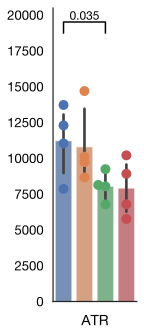

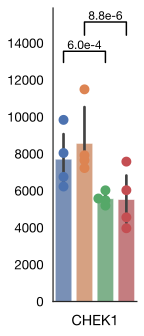

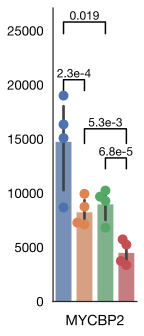

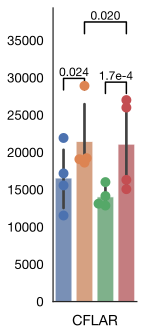

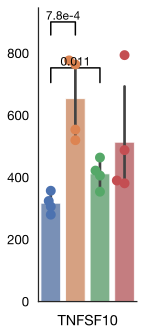

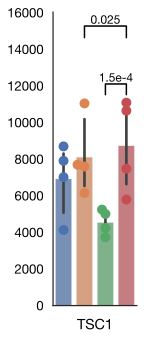

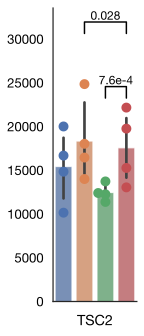

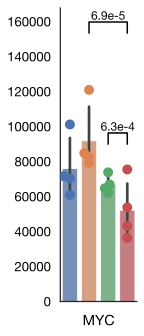

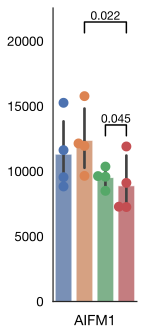

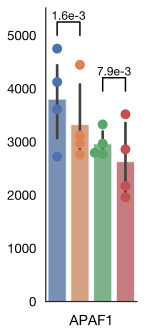

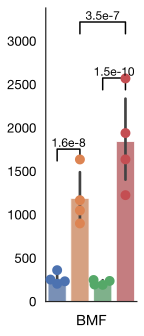

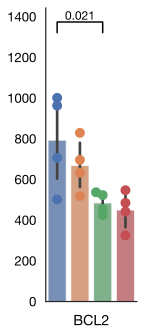

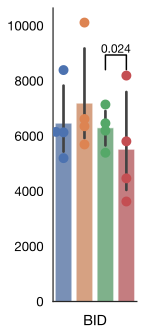

In [103]:
os.chdir("/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/plots/")

set_matplotlib_formats("svg")
sb.set(font_scale=1.2)
pd.set_option('display.width', 400)
pd.set_option('display.max_rows', 200)
plt.style.use('seaborn-ticks')
rcParams['figure.figsize'] = (8,4)
rcParams['figure.dpi'] = 200
rcParams['font.size'] = 12
rcParams['font.family'] = 'Helvetica Neue'

COLOR = 'black'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

genes="""ATR
CHEK1
MYCBP2
CFLAR
TNFSF10
TSC1
TSC2
MYC
AIFM1
APAF1
BMF
BCL2
BID""".strip().split("\n")

col_order = ["control","si6","control_Cis","si6_Cis"]

g = None

count = 0

for gene in genes:
    df = all_samples[all_samples["Symbol"]==gene]
    df.set_index("Symbol",inplace=True)
    new_df = []
    for samp,row in meta_mycbp2.iterrows():
        expr = df.loc[gene,samp]
        group = row["group"]
        new_df.append({gene:expr,"group":group})
    df = pd.DataFrame(new_df)
    
    g = sb.catplot(x="group", y=gene, kind="swarm", data=df,order=col_order,aspect=0.5,s=10,)
    ax = sb.barplot(x="group", y=gene, data=df,alpha=0.8,order=col_order,ax=g.ax)
    ax.set(xticklabels=[])
    sb.despine(ax=ax)
    plt.sca(ax)
    plt.xlabel(gene)
    plt.ylabel(None)

    cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
    reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1
    control_cis_sig = controlcis_control.loc[gene,"adj.P.Val"] if gene in controlcis_control.index else 1
    si6_cis_sig = si6cis_si6.loc[gene,"adj.P.Val"] if gene in si6cis_si6.index else 1

    if cis_sig < 0.05:
        heights = [p.get_height()*1.25 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(2,3,""+to_precision(cis_sig,2),bars,heights,fs=12)

    if reg_sig < 0.05:
        heights = [p.get_height()*1.25 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(0,1,""+to_precision(reg_sig,2),bars,heights,fs=12)
    
    if control_cis_sig < 0.05:
        heights = [p.get_height()*1.6 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(0,2,""+to_precision(control_cis_sig,2),bars,heights,fs=12)

    if si6_cis_sig < 0.05:
        heights = [p.get_height()*1.6 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(1,3,""+to_precision(si6_cis_sig,2),bars,heights,fs=12)
    
    plt.show()
    

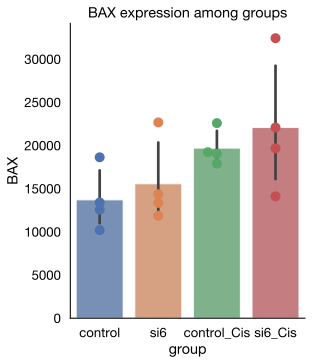

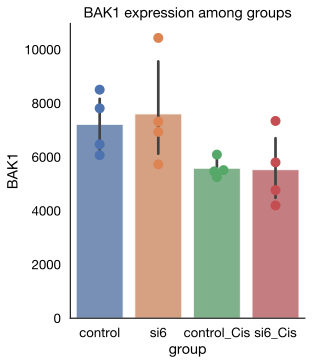

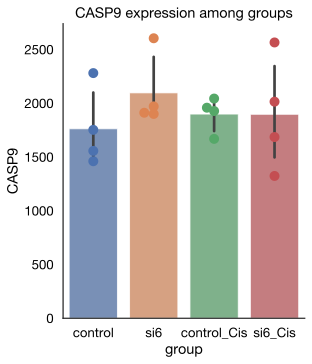

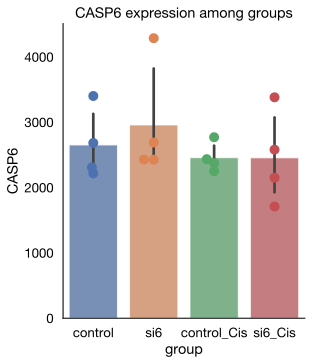

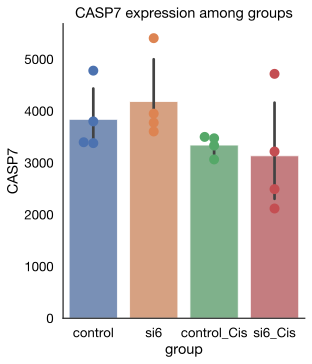

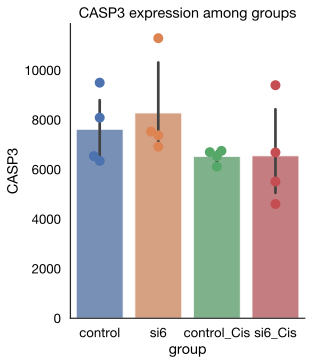

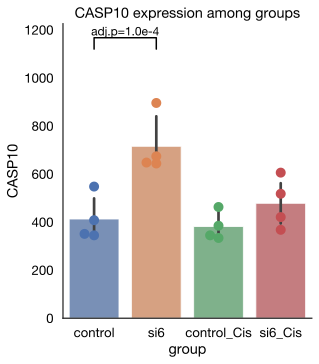

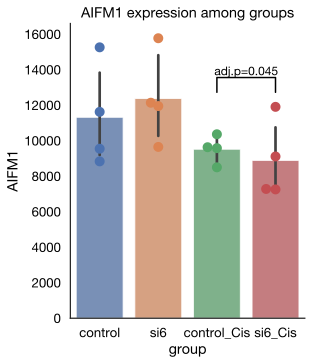

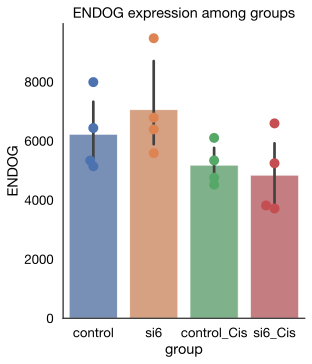

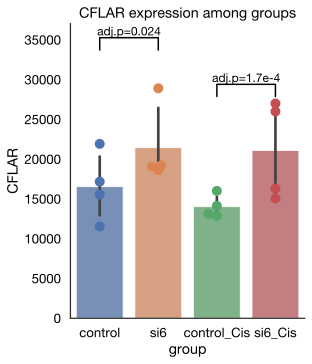

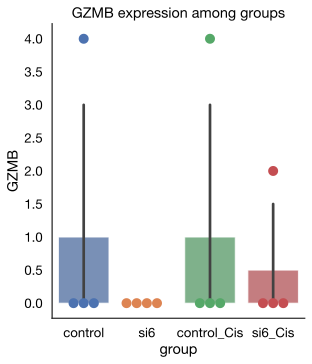

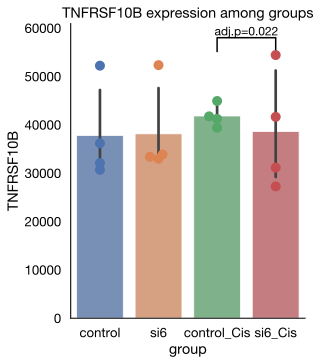

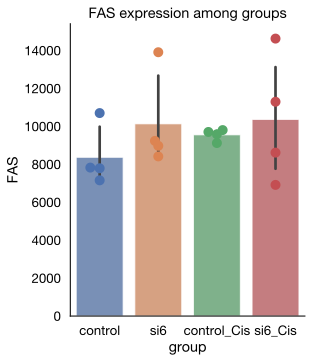

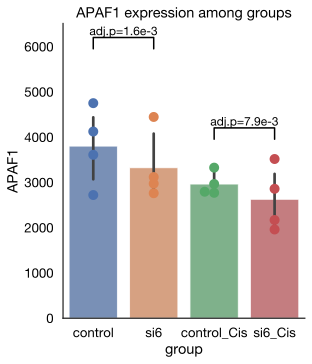

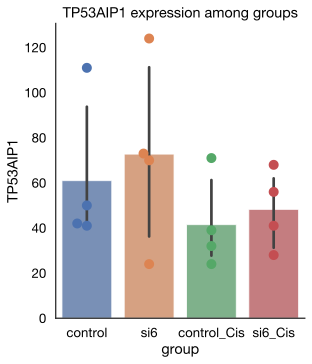

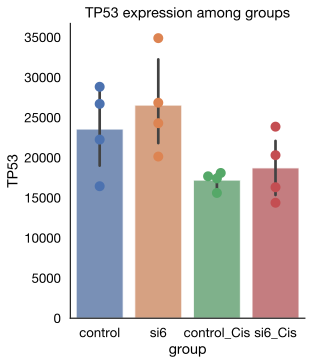

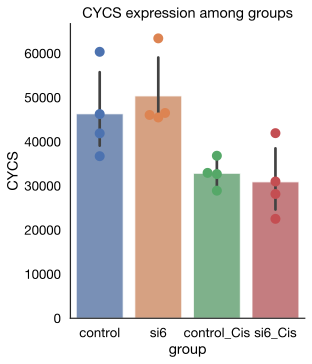

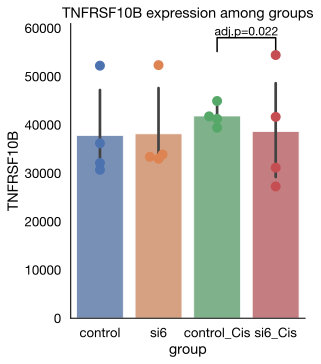

In [57]:
os.chdir("/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/plots/")

genes="""BAX
BAK1
CASP9
CASP6
CASP7
CASP3
CASP10
AIFM1
ENDOG
CFLAR
GZMB
TNFRSF10B
FAS
APAF1
TP53AIP1
TP53
CYCS
TNFRSF10B""".strip().split("\n")

col_order = ["control","si6","control_Cis","si6_Cis"]

g = None

for gene in genes:
    df = all_samples[all_samples["Symbol"]==gene]
    df.set_index("Symbol",inplace=True)
    new_df = []
    for samp,row in meta_mycbp2.iterrows():
        expr = df.loc[gene,samp]
        group = row["group"]
        new_df.append({gene:expr,"group":group})
    df = pd.DataFrame(new_df)
    
    g = sb.catplot(x="group", y=gene, kind="swarm", data=df,order=col_order,aspect=0.9,s=10)
    ax = sb.barplot(x="group", y=gene, data=df,alpha=0.8,order=col_order,ax=g.ax,)
    plt.sca(ax)
    plt.title("{} expression among groups".format(gene))

    cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
    reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

    if cis_sig < 0.05:
        heights = [p.get_height()*1.25 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

    if reg_sig < 0.05:
        heights = [p.get_height()*1.50 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)
    
    plt.sca(ax)
    
    sb.despine(ax=ax)
    
    
    f = plt.gcf()
    f.savefig("{}_expr.pdf".format(gene), bbox_inches='tight')
    #plt.show()
    #time.sleep(1)

/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

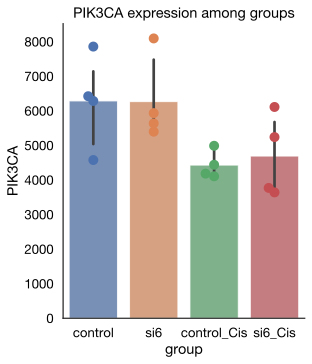

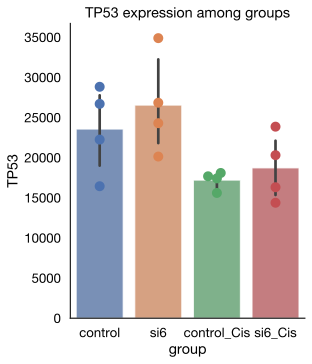

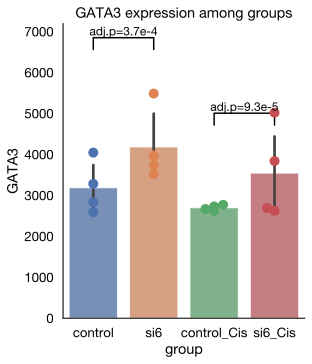

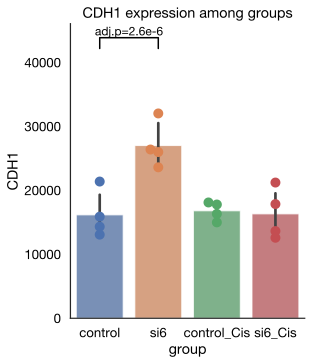

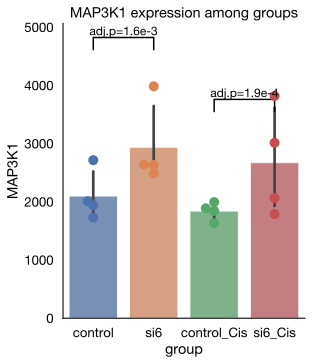

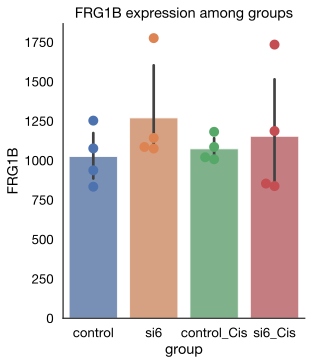

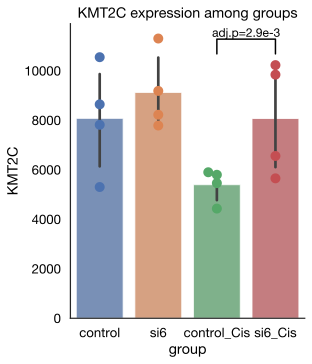

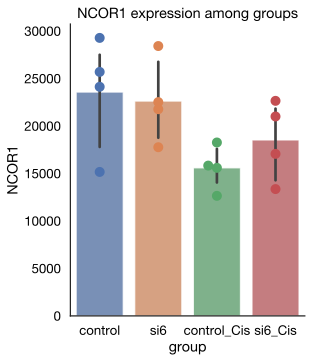

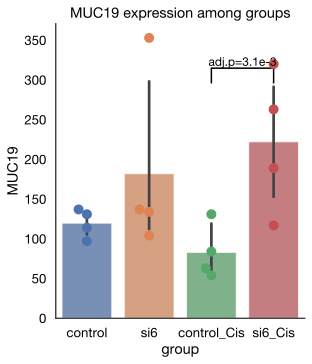

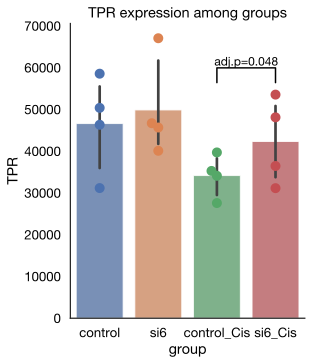

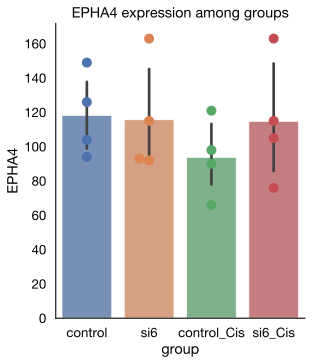

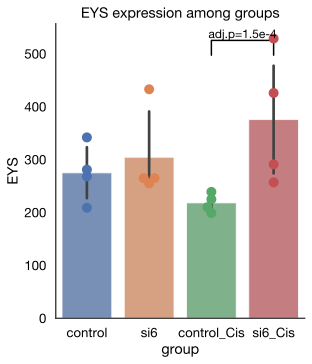

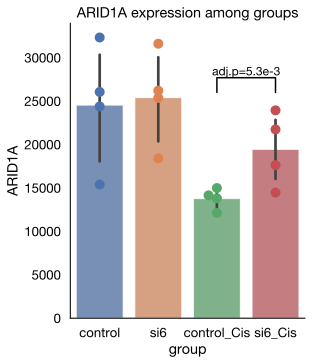

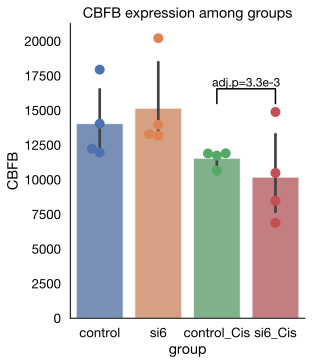

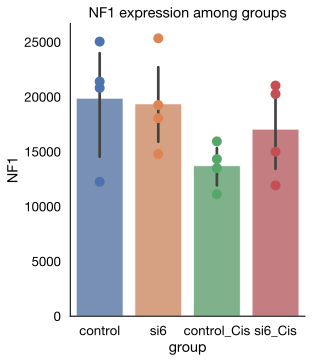

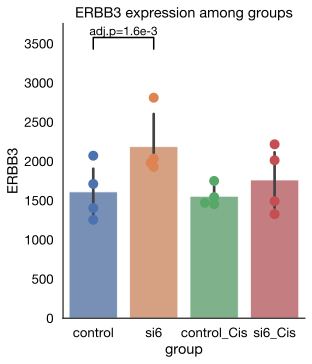

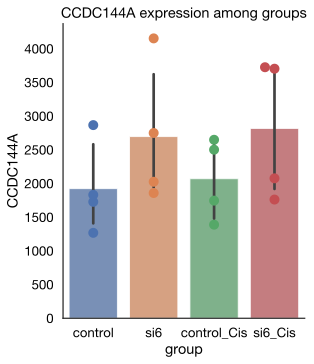

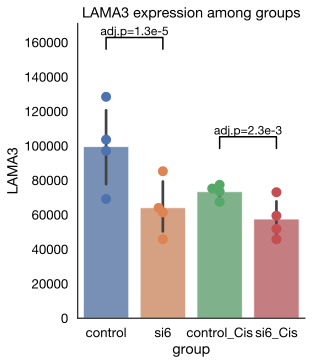

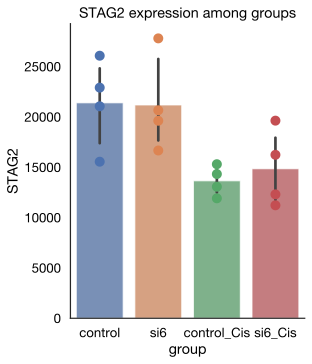

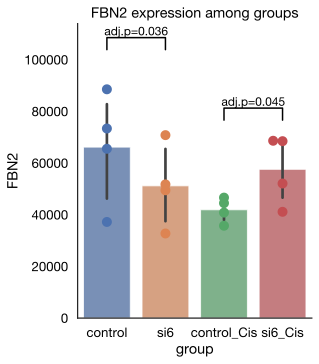

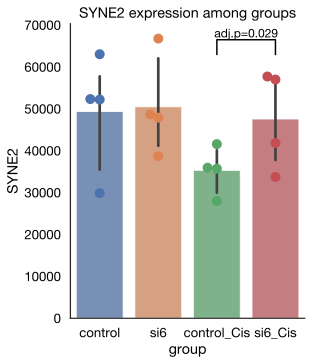

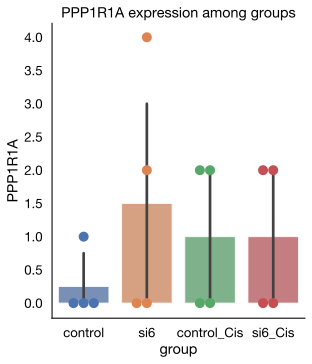

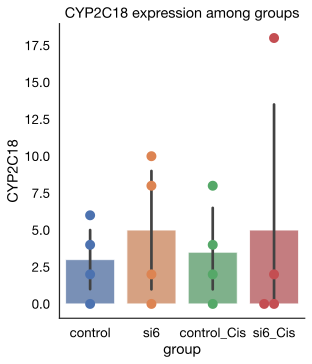

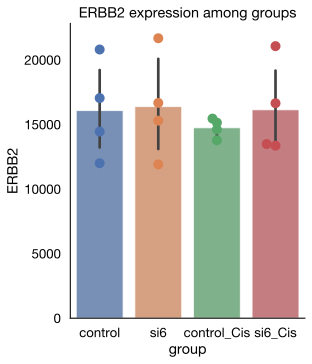

In [14]:
os.chdir("/sc/arion/projects/zhangb03a/neffr01/MycBP2_data/processed/plots/")

genes= """PIK3CA
TP53
GATA3
CDH1
MAP3K1
FRG1B
KMT2C
NCOR1
MUC19
TPR
EPHA4
EYS
ARID1A
CBFB
NF1
ERBB3
CCDC144A
LAMA3
STAG2
FBN2
SYNE2
PPP1R1A
CYP2C18
ERBB2"""
genes = genes.strip().split("\n")

col_order = ["control","si6","control_Cis","si6_Cis"]

g = None

for gene in genes:
    df = all_samples[all_samples["Symbol"]==gene]
    df.set_index("Symbol",inplace=True)
    new_df = []
    for samp,row in meta_mycbp2.iterrows():
        expr = df.loc[gene,samp]
        group = row["group"]
        new_df.append({gene:expr,"group":group})
    df = pd.DataFrame(new_df)
    
    g = sb.catplot(x="group", y=gene, kind="swarm", data=df,order=col_order,aspect=0.9,s=10)
    ax = sb.barplot(x="group", y=gene, data=df,alpha=0.8,order=col_order,ax=g.ax,)
    plt.sca(ax)
    plt.title("{} expression among groups".format(gene))

    cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
    reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

    if cis_sig < 0.05:
        heights = [p.get_height()*1.25 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

    if reg_sig < 0.05:
        heights = [p.get_height()*1.50 for p in ax.patches]
        bars = np.arange(len(heights))
        barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)
    
    plt.sca(ax)
    
    sb.despine(ax=ax)
    
    
    f = plt.gcf()
    f.savefig("{}_expr.pdf".format(gene), bbox_inches='tight')
    #plt.show()
    #time.sleep(1)

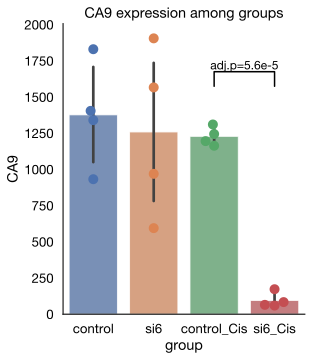

In [16]:
set_matplotlib_formats("svg")
sb.set(font_scale=1.2)
pd.set_option('display.width', 400)
pd.set_option('display.max_rows', 200)
plt.style.use('seaborn-ticks')
rcParams['figure.figsize'] = (8,4)
rcParams['figure.dpi'] = 200
rcParams['font.size'] = 12
rcParams['font.family'] = 'Helvetica Neue'

COLOR = 'black'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

gene = "CA9"
df = all_samples[all_samples["Symbol"]==gene]
df.set_index("Symbol",inplace=True)
new_df = []
for samp,row in meta_mycbp2.iterrows():
    expr = df.loc[gene,samp]
    group = row["group"]
    new_df.append({gene:expr,"group":group})
df = pd.DataFrame(new_df)
col_order = ["control","si6","control_Cis","si6_Cis"]
g = sb.catplot(x="group", y=gene, kind="swarm", order=col_order, data=df,aspect=0.9,s=10)
sb.barplot(x="group", y=gene, data=df,ax=g.ax,alpha=0.8, order=col_order)
plt.title("{} expression among groups".format(gene))

cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

if cis_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

if reg_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)

plt.show()

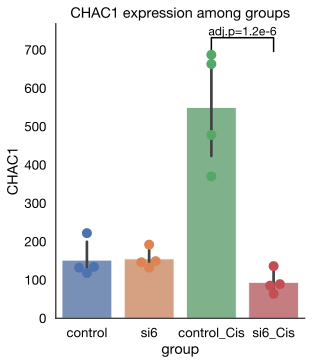

In [17]:
gene = "CHAC1"
df = all_samples[all_samples["Symbol"]==gene]
df.set_index("Symbol",inplace=True)
new_df = []
for samp,row in meta_mycbp2.iterrows():
    expr = df.loc[gene,samp]
    group = row["group"]
    new_df.append({gene:expr,"group":group})
df = pd.DataFrame(new_df)
col_order = ["control","si6","control_Cis","si6_Cis"]
g = sb.catplot(x="group", y=gene, kind="swarm", order=col_order, data=df,aspect=0.9,s=10)
sb.barplot(x="group", y=gene, data=df,ax=g.ax,alpha=0.8, order=col_order)
plt.title("{} expression among groups".format(gene))

cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

if cis_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

if reg_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)

plt.show()

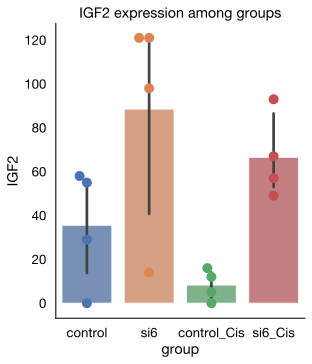

In [18]:
gene = "IGF2"
df = all_samples[all_samples["Symbol"]==gene]
df.set_index("Symbol",inplace=True)
new_df = []
for samp,row in meta_mycbp2.iterrows():
    expr = df.loc[gene,samp]
    group = row["group"]
    new_df.append({gene:expr,"group":group})
df = pd.DataFrame(new_df)
col_order = ["control","si6","control_Cis","si6_Cis"]
g = sb.catplot(x="group", y=gene, kind="swarm", order=col_order, data=df,aspect=0.9,s=10)
sb.barplot(x="group", y=gene, data=df,ax=g.ax,alpha=0.8, order=col_order)
plt.title("{} expression among groups".format(gene))

cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

if cis_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

if reg_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)

plt.show()

In [19]:
diffexp_cis = si6cis_controlcis[si6cis_controlcis["adj.P.Val"]<0.05]
diffexp_nl = si6_control[si6_control["adj.P.Val"]<0.05] 
diffexp_cis.loc[diffexp_cis.index.difference(diffexp_nl.index),:].sort_values("adj.P.Val")

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IL1RL1,1.649260,4.881434,18.875283,1.159301e-12,4.575656e-09,19.320704
ASNS,-1.219137,4.327072,-15.944175,1.667871e-11,1.662942e-08,16.714437
BHLHE40,-1.184001,6.372637,-15.900426,1.741193e-11,1.662942e-08,16.654483
TBX3,0.742062,4.494552,12.881229,4.494483e-10,1.381931e-07,13.411838
ZEB2,1.167884,3.040500,12.461479,7.424023e-10,1.870607e-07,12.954169
ELOVL6,-0.655997,6.987351,-12.349066,8.512021e-10,1.919461e-07,12.697499
FGFBP1,-1.860234,5.940024,-11.990029,1.326532e-09,2.692198e-07,12.288499
RP11.346D6.6,1.402172,3.464362,11.876316,1.530086e-09,2.957438e-07,12.229106
ATOH8,1.245033,2.764472,11.590802,2.200390e-09,3.864533e-07,11.856971
SREBF1,-0.591024,7.417020,-11.537160,2.357696e-09,4.072293e-07,11.659416


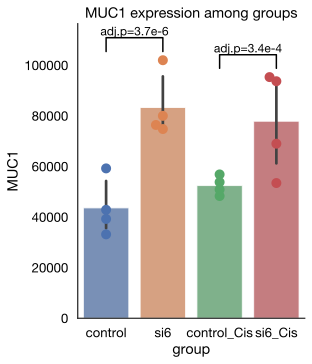

In [20]:
gene = "MUC1"
df = all_samples[all_samples["Symbol"]==gene]
df.set_index("Symbol",inplace=True)
new_df = []
for samp,row in meta_mycbp2.iterrows():
    expr = df.loc[gene,samp]
    group = row["group"]
    new_df.append({gene:expr,"group":group})
df = pd.DataFrame(new_df)
col_order = ["control","si6","control_Cis","si6_Cis"]
g = sb.catplot(x="group", y=gene, kind="swarm", order=col_order, data=df,aspect=0.9,s=10)
sb.barplot(x="group", y=gene, data=df,ax=g.ax,alpha=0.8, order=col_order)
plt.title("{} expression among groups".format(gene))

cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

if cis_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

if reg_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)

plt.show()

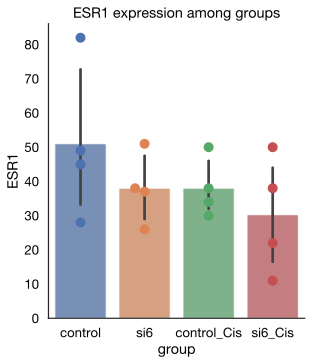

In [22]:
gene = "ESR1"
df = all_samples[all_samples["Symbol"]==gene]
df.set_index("Symbol",inplace=True)
new_df = []
for samp,row in meta_mycbp2.iterrows():
    expr = df.loc[gene,samp]
    group = row["group"]
    new_df.append({gene:expr,"group":group})
df = pd.DataFrame(new_df)
col_order = ["control","si6","control_Cis","si6_Cis"]
g = sb.catplot(x="group", y=gene, kind="swarm", order=col_order, data=df,aspect=0.9,s=10)
sb.barplot(x="group", y=gene, data=df,ax=g.ax,alpha=0.8, order=col_order)
plt.title("{} expression among groups".format(gene))

cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

if cis_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

if reg_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)

plt.show()

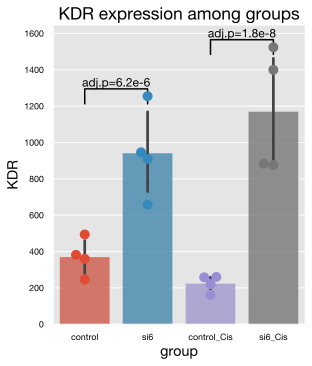

In [33]:
gene = "KDR"
df = all_samples[all_samples["Symbol"]==gene]
df.set_index("Symbol",inplace=True)
new_df = []
for samp,row in meta_mycbp2.iterrows():
    expr = df.loc[gene,samp]
    group = row["group"]
    new_df.append({gene:expr,"group":group})
df = pd.DataFrame(new_df)
col_order = ["control","si6","control_Cis","si6_Cis"]
g = sb.catplot(x="group", y=gene, kind="swarm", order=col_order, data=df,aspect=0.9,s=10)
sb.barplot(x="group", y=gene, data=df,ax=g.ax,alpha=0.8, order=col_order)
plt.title("{} expression among groups".format(gene))

cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

if cis_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

if reg_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)

plt.show()

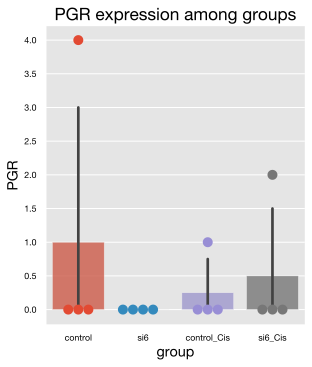

In [34]:
gene = "PGR"
df = all_samples[all_samples["Symbol"]==gene]
df.set_index("Symbol",inplace=True)
new_df = []
for samp,row in meta_mycbp2.iterrows():
    expr = df.loc[gene,samp]
    group = row["group"]
    new_df.append({gene:expr,"group":group})
df = pd.DataFrame(new_df)
col_order = ["control","si6","control_Cis","si6_Cis"]
g = sb.catplot(x="group", y=gene, kind="swarm", order=col_order, data=df,aspect=0.9,s=10)
sb.barplot(x="group", y=gene, data=df,ax=g.ax,alpha=0.8, order=col_order)
plt.title("{} expression among groups".format(gene))

cis_sig = si6cis_controlcis.loc[gene,"adj.P.Val"] if gene in si6cis_controlcis.index else 1
reg_sig = si6_control.loc[gene,"adj.P.Val"] if gene in si6_control.index else 1

if cis_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(2,3,"adj.p="+to_precision(cis_sig,2),bars,heights,fs=12)

if reg_sig < 0.05:
    heights = [p.get_height()*1.2 for p in g.ax.patches]
    bars = np.arange(len(heights))
    barplot_annotate_brackets(0,1,"adj.p="+to_precision(reg_sig,2),bars,heights,fs=12)

plt.show()

In [35]:
gsea_result_cis = pd.read_table("../DEGs/si6cis_vs_controlcis_gsea_enrichment.tsv", sep=" ")
gsea_result_cis.set_index("MSigDB",inplace=True)

gsea_result_normal = pd.read_table("../DEGs/si6_vs_control_gsea_enrichment.tsv", sep=" ")
gsea_result_normal.set_index("MSigDB",inplace=True)

gsea_result_control = pd.read_table("../DEGs/controlcis_vs_control_gsea_enrichment.tsv", sep=" ")
gsea_result_control.set_index("MSigDB",inplace=True)

gsea_result_si6 = pd.read_table("../DEGs/si6cis_vs_si6_gsea_enrichment.tsv", sep=" ")
gsea_result_si6.set_index("MSigDB",inplace=True)

/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/hpc/users/neffr01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead.
  # Remove the CWD from sys.path while we load stuff.


In [36]:
merged = pd.concat([gsea_result_cis.loc[:,"ES"],gsea_result_normal.loc[:,"ES"],
          gsea_result_control.loc[:,"ES"],gsea_result_si6.loc[:,"ES"]],axis=1,sort=True,
          keys=["si6_cis-control_cis","si6-control","control_cis-control","si6_cis-si6"])

In [37]:
merged

,si6_cis-control_cis,si6-control,control_cis-control,si6_cis-si6
GO_14_3_3_PROTEIN_BINDING,0.000000,0.000000,-0.254531,0.367061
GO_1_PHOSPHATIDYLINOSITOL_BINDING,0.000000,0.000000,-0.195481,0.410723
GO_2_IRON_2_SULFUR_CLUSTER_BINDING,0.000000,0.000000,0.193259,-0.475855
GO_2_OXOGLUTARATE_METABOLIC_PROCESS,0.000000,0.000000,-0.169520,-0.509149
GO_3_5_CYCLIC_AMP_PHOSPHODIESTERASE_ACTIVITY,0.000000,0.000000,-0.265925,-0.434270
GO_3_5_CYCLIC_GMP_PHOSPHODIESTERASE_ACTIVITY,0.000000,0.000000,-0.502464,-0.275242
GO_3_5_DNA_HELICASE_ACTIVITY,0.000000,0.000000,-0.508017,-0.671609
GO_3_5_EXONUCLEASE_ACTIVITY,0.000000,0.000000,-0.472198,-0.559034
GO_3_UTR_MEDIATED_MRNA_STABILIZATION,0.000000,0.000000,-0.258356,-0.317168
GO_4_HYDROXYPROLINE_METABOLIC_PROCESS,0.000000,0.000000,0.536175,0.348143


In [38]:
merged["total_change"] = abs(merged["si6_cis-control_cis"]+merged["si6-control"])-\
    abs(merged["control_cis-control"]+merged["si6_cis-si6"])

In [39]:
merged_select = merged[(merged.index.str.contains("APOPTOSIS"))|(merged.index.str.contains("CELL_CYCLE"))]

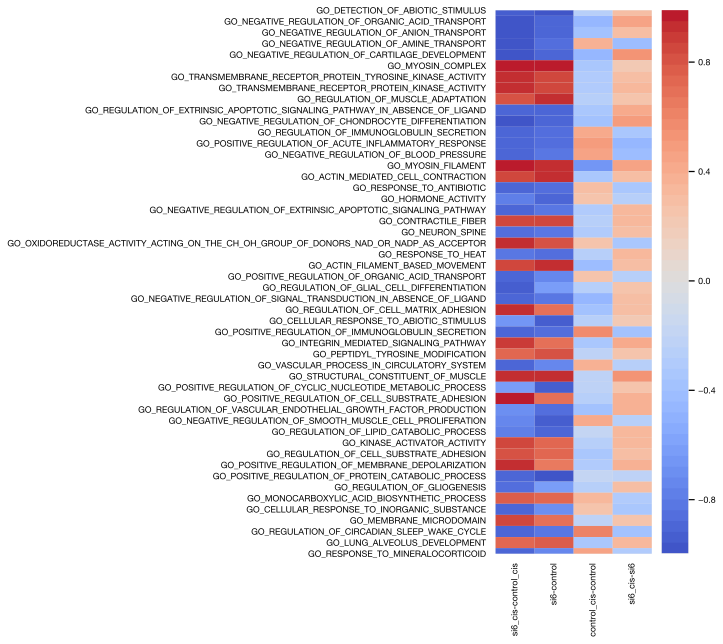

In [40]:
rcParams["figure.figsize"] = (3.5,10)
sb.set(font_scale=0.8)
pd.set_option('display.width', 400)
pd.set_option('display.max_rows', 200)
plt.style.use('ggplot')
rcParams['figure.dpi'] = 200
rcParams['font.size'] = 12
rcParams['font.family'] = 'Helvetica Neue'

COLOR = 'black'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

sb.heatmap(merged.sort_values(by="total_change",ascending=False).iloc[0:50,0:4],cmap=sb.color_palette("coolwarm",50))


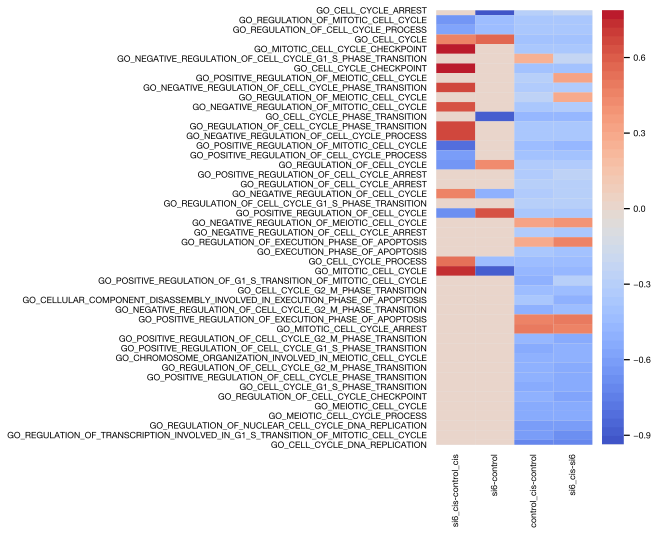

In [41]:
rcParams["figure.figsize"] = (3.5,8)

sb.heatmap(merged_select.sort_values(by="total_change",ascending=False).iloc[0:100,0:4],cmap=sb.color_palette("coolwarm",50))